In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import urllib
import folium
import json
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import scipy
import scipy.stats as sp
import scipy.optimize as op
import statsmodels.api as sm
from scipy.stats import linregress
from scipy.optimize import curve_fit
from scipy import stats

from datetime import datetime, date, timedelta
from matplotlib.backends.backend_pdf import PdfPages
#from matplotlib.pyplot import cm 
import platform
import sys
import glob

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pyproj
from pyproj import Proj
import simplekml

import os  
import csv

#import matplotlib
from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

In [3]:
import wellapplication as wa

# Read in and Convert PRISM output

In [9]:
lat = []
lon = []
elev=[]
idlist = []
namelist = []
tempnamelist = []
csv.field_size_limit(500 * 1024 * 1024)
csv_dir = 'C:/Users/kladig/Documents/SWAT/Bryce/PRISM/'
i=0

pptfile = {}
tempfile = {}
os.chdir(csv_dir)
for csv_file in glob.glob("*.csv"):
    i += 1
    idlist.append(i)
    namelist.append('p'+str(i))
    tempnamelist.append('t'+str(i))
    print(csv_file)
    csvFileArray = []

    with open(csv_file, newline='') as csvfile:
        for row in csv.reader(csvfile):
            csvFileArray.append(row)
    loclist = str(csvFileArray[1]).split(':')
    lat.append(float(loclist[2].split(' ')[1]))
    lon.append(float(loclist[3].split(' ')[1]))
    elev.append(float(loclist[4].split(' ')[1][:-3]))
    
    pptdf = pd.read_csv(csv_file,skiprows=10,usecols=[0,1],index_col=0,parse_dates=[0])
    pptdf = pptdf.loc['2000-01-01':]
    pptdf.columns = ['20000101']
    pptdf.to_csv(csv_dir+'outfiles/'+'p'+str(i)+'.csv',index=False)
    
    tempdf = pd.read_csv(csv_file,skiprows=10,usecols=[0,2,4],index_col=0,parse_dates=[0])
    tempdf.columns = ['20000101','']
    tempdf = tempdf.loc['2000-01-01':]
    tempdf.to_csv(csv_dir+'outfiles/'+'t'+str(i)+'.csv',index=False)
    
colms = {'ID':idlist,'NAME':namelist,'LAT':lat,'LONG':lon,'ELEVATION':elev}
df = pd.DataFrame(colms)
df = df[['ID','NAME','LAT','LONG','ELEVATION']]
df.to_csv(csv_dir+'outfiles/'+'pcp.txt',index=False)

colms2 = {'ID':idlist,'NAME':tempnamelist,'LAT':lat,'LONG':lon,'ELEVATION':elev}
df2 = pd.DataFrame(colms2)
df2 = df2[['ID','NAME','LAT','LONG','ELEVATION']]
df2.to_csv(csv_dir+'outfiles/'+'tmp.txt',index=False)

PRISM_ppt_tmin_tmean_tmax_tdmean_vpdmin_vpdmax_stable_4km_20000101_20210101_37.5097_-112.3231.csv
PRISM_ppt_tmin_tmean_tmax_tdmean_vpdmin_vpdmax_stable_4km_20000101_20210101_37.5936_-112.2504.csv
PRISM_ppt_tmin_tmean_tmax_tdmean_vpdmin_vpdmax_stable_4km_20000101_20210101_37.8271_-112.0374.csv
PRISM_ppt_tmin_tmean_tmax_tdmean_vpdmin_vpdmax_stable_4km_20000101_20210101_37.8721_-111.9467.csv
PRISM_ppt_tmin_tmean_tmax_tdmean_vpdmin_vpdmax_stable_4km_20000101_20210101_37.9193_-112.0408.csv


In [6]:
pptdf.loc['2000-01-01':]

,20000101
Date,
2000-01-01,0.30
2000-01-02,0.04
2000-01-03,1.12
2000-01-04,0.00
2000-01-05,0.00
...,...
2020-12-28,2.34
2020-12-29,9.67
2020-12-30,0.00


# Read in USGS Data

In [12]:
24*60*60

86400

In [16]:
0.0283168*60*60*24

2446.5715200000004

connection successful
connection successful
Gage height, feet skipped!


<AxesSubplot:xlabel='Date'>

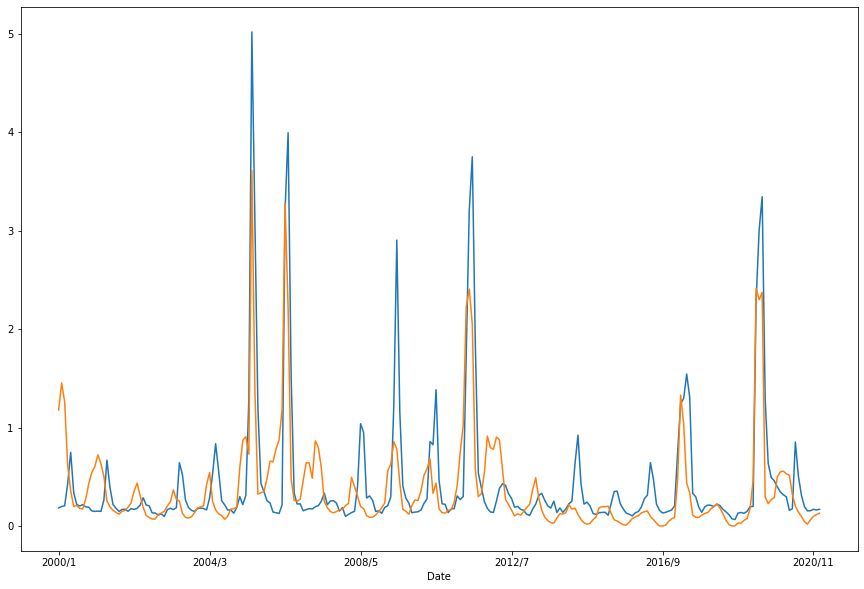

In [20]:
usgs_salt = wa.nwis('dv',10146000,'sites')
usgs_salt_daily = usgs_salt.data['value'].to_frame()
usgs_salt_daily['cms'] = usgs_salt_daily['value']*0.0283168

usgs_salt_monthly = usgs_salt_daily.groupby(pd.Grouper(level=0,freq='1MS')).mean()

usgs_salt_monthly = usgs_salt_monthly.rename(columns={'cms':'Flow'})
usgs_salt_monthly = usgs_salt_monthly['2000-01-01':'2021-01-01']
usgs_salt_monthly['date'] = usgs_salt_monthly.index
usgs_salt_monthly['abdate'] = usgs_salt_monthly['date'].apply(lambda x: f"{x:%Y/%#m}",1)
usgs_salt_monthly.index = usgs_salt_monthly['abdate']
usgs_salt_monthly.index.name = 'Date'
usgs_salt_monthly = usgs_salt_monthly['Flow'].to_frame().round(3)
usgs_salt_monthly.to_csv(r"C:\Users\paulinkenbrandt\Documents\Projects\Juab\River_Files\salt_mon.csv")
usgs_salt_monthly['Flow'].plot()

site=10146400
usgs_salt = wa.nwis('dv',10146400,'sites')
if usgs_salt.data.index.nlevels > 1:
    usgs_salt_daily = usgs_salt.data.loc[str(site),'value'].to_frame()
else:
    usgs_salt_daily = usgs_salt.data['value'].to_frame()
#usgs_salt_daily = usgs_salt.data['value'].to_frame()
usgs_salt_daily['cms'] = usgs_salt_daily['value']*0.0283168
usgs_salt_monthly = usgs_salt_daily.groupby(pd.Grouper(level=0,freq='1MS')).mean()

usgs_salt_monthly = usgs_salt_monthly.rename(columns={'cms':'Flow'})
usgs_salt_monthly = usgs_salt_monthly['2000-01-01':'2021-01-01']
usgs_salt_monthly['date'] = usgs_salt_monthly.index
usgs_salt_monthly['abdate'] = usgs_salt_monthly['date'].apply(lambda x: f"{x:%Y/%#m}",1)
usgs_salt_monthly.index = usgs_salt_monthly['abdate']
usgs_salt_monthly.index.name = 'Date'
usgs_salt_monthly = usgs_salt_monthly['Flow'].to_frame().round(3)
usgs_salt_monthly.to_csv(r"C:\Users\paulinkenbrandt\Documents\Projects\Juab\River_Files\curr_mon.csv")
usgs_salt_monthly['Flow'].plot()

<AxesSubplot:xlabel='Date'>

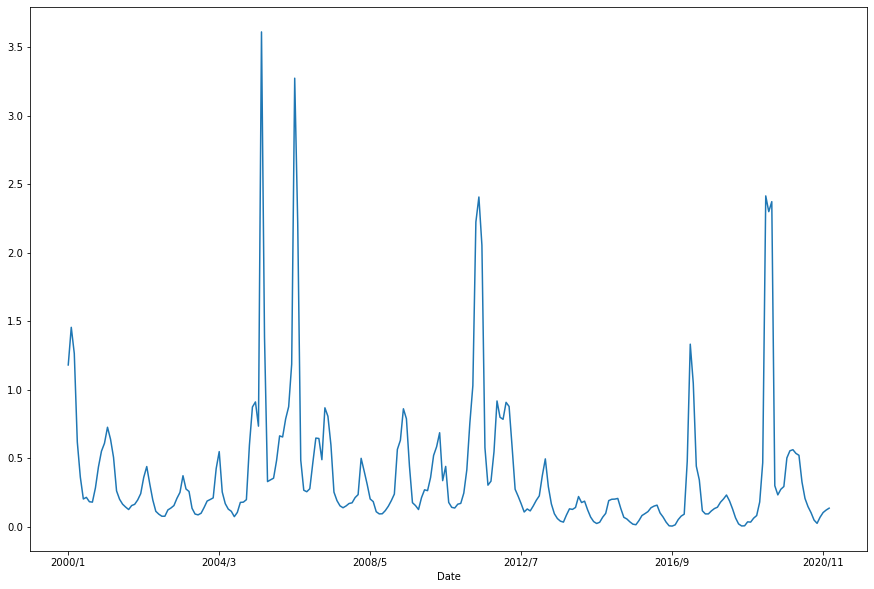

In [18]:
usgs_salt_monthly['Flow'].plot()

In [12]:
usgs_salt = wa.nwis('dv',10146000,'sites')
usgs_salt_daily = usgs_salt.data['value'].to_frame()
usgs_salt_daily['cms'] = usgs_salt_daily['value']*0.0283168
usgs_salt_daily = usgs_salt_daily.rename(columns={'cms':'Flow'})
usgs_salt_daily = usgs_salt_daily['2000-01-01':'2021-01-01']

usgs_salt_daily = usgs_salt_daily.resample('1D').asfreq().interpolate(method='time').round(3)
usgs_salt_daily = usgs_salt_daily.sort_index()
usgs_salt_daily['date'] = usgs_salt_daily.index

usgs_salt_daily['abdate'] = usgs_salt_daily['date'].apply(lambda x: f"{x:%d/%m/%Y}",1)
usgs_salt_daily.index = usgs_salt_daily['abdate']

usgs_salt_daily = usgs_salt_daily['Flow'].to_frame()
usgs_salt_daily.index.name = 'Date'

usgs_salt_daily.to_csv(r"C:\Users\paulinkenbrandt\Documents\Projects\Juab\River_Files\salt_daily.csv")

connection successful


<AxesSubplot:xlabel='Date'>

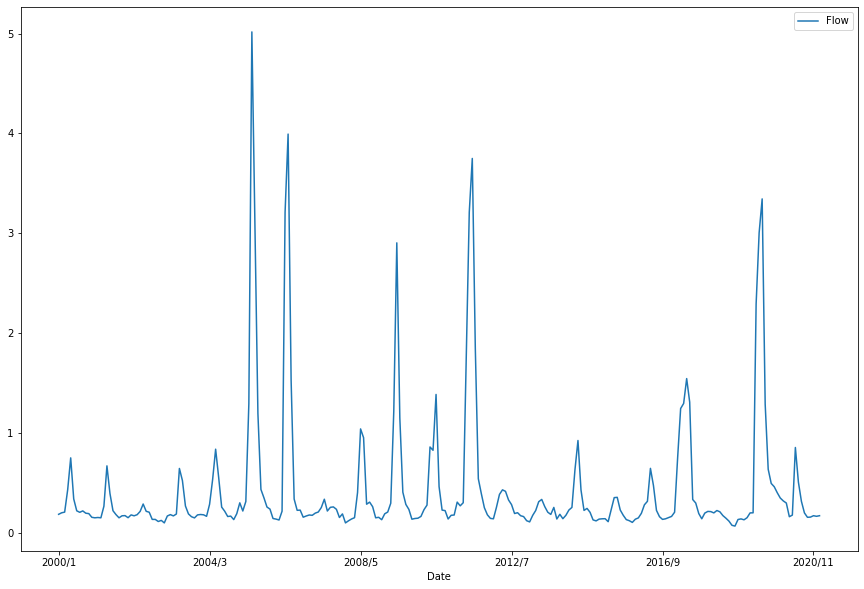

In [8]:
usgs_salt_monthly.plot()

In [32]:
usgsc = wa.nwis('dv', 10146000,'sites')
usgsc.data

connection successful


,value,qualifiers,site_no
datetime,,,
1950-12-01,11.00,[A],10146000
1950-12-02,11.00,[A],10146000
1950-12-03,11.00,[A],10146000
1950-12-04,13.00,[A],10146000
1950-12-05,12.00,[A],10146000
...,...,...,...
2021-06-26,9.46,[P],10146000
2021-06-27,8.90,[P],10146000
2021-06-28,8.48,[P],10146000


In [37]:
def usgs_daily(site=10146400, beg_date='2000-01-01',end_date='2021-01-01', 
               out_file=r"C:\Users\paulinkenbrandt\Documents\Projects\Juab\River_Files\currant_daily.csv"):
    usgs = wa.nwis('dv', site,'sites')
    if usgs.data.index.nlevels > 1:
        usgs_daily = usgs.data.loc[str(site),'value'].to_frame()
    else:
        usgs_daily = usgs.data['value'].to_frame()
    usgs_daily['cms'] = usgs_daily['value']*0.0283168
    usgs_daily = usgs_daily.rename(columns={'cms':'Flow'})
    usgs_daily = usgs_daily[beg_date:end_date]

    usgs_daily = usgs_daily.resample('1D').asfreq().interpolate(method='time').round(3)
    usgs_daily = usgs_daily.sort_index()
    usgs_daily['date'] = usgs_daily.index

    #usgs_daily['abdate'] = usgs_daily['date'].apply(lambda x: f"{x:%d/%m/%Y}",1)
    #usgs_daily.index = usgs_daily['abdate']

    usgs_daily = usgs_daily['Flow'].to_frame()
    usgs_daily.index.name = 'Date'

    usgs_daily.to_csv(out_file)
    return usgs_daily



In [38]:

salt = usgs_daily(site=10146000,
                  out_file=r"C:\Users\paulinkenbrandt\Documents\Projects\Juab\River_Files\salt_daily.csv")
currant = usgs_daily(site=10146400,
                  out_file=r"C:\Users\paulinkenbrandt\Documents\Projects\Juab\River_Files\currant_daily.csv")

connection successful
connection successful
Gage height, feet skipped!


In [11]:
site=10146400
usgs_salt = wa.nwis('dv',10146400,'sites')
if usgs_salt.data.index.nlevels > 1:
    usgs_salt_daily = usgs_salt.data.loc[str(site),'value'].to_frame()
else:
    usgs_salt_daily = usgs_salt.data['value'].to_frame()
#usgs_salt_daily = usgs_salt.data['value'].to_frame()
usgs_salt_daily['cms'] = usgs_salt_daily['value']*0.0283168
usgs_salt_monthly = usgs_salt_daily.groupby(pd.Grouper(level=0,freq='1MS')).mean()

usgs_salt_monthly = usgs_salt_monthly.rename(columns={'cms':'Flow'})
usgs_salt_monthly = usgs_salt_monthly['2000-01-01':'2021-01-01']
usgs_salt_monthly['date'] = usgs_salt_monthly.index
usgs_salt_monthly['abdate'] = usgs_salt_monthly['date'].apply(lambda x: f"{x:%Y/%#m}",1)
usgs_salt_monthly.index = usgs_salt_monthly['abdate']
usgs_salt_monthly.index.name = 'Date'
usgs_salt_monthly = usgs_salt_monthly['Flow'].to_frame().round(3)
usgs_salt_monthly.to_csv(r"C:\Users\paulinkenbrandt\Documents\Projects\Juab\River_Files\curr_mon.csv")

connection successful
Gage height, feet skipped!


<AxesSubplot:xlabel='Date'>

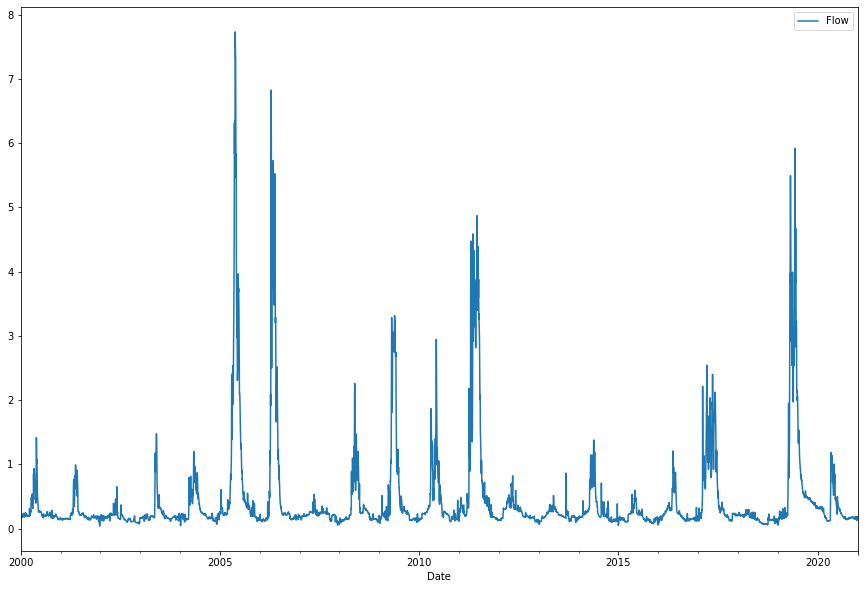

In [21]:
currant.plot()